In [29]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from dateutil.relativedelta import relativedelta

import networkx as nx

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得する。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいく。

- 前提条件
  - 部品を保管する倉庫から、生産工場に部品を輸送している
  - 各倉庫と工場の区間の輸送コストは、過去でデータから定量的に設定されている
  - 集計期間は、「20190101」~「20191231」
  - 関東支社と東北支社のデータをシステムから抽出し、CSVとして提供されている
- データ一覧
  - tbl_factory.csv（生産工場のデータ）
  - tbl_warehouse.csv（倉庫のデータ）
  - rel_cost.csv（倉庫と工場間の輸送コスト）
  - tbl_transaction.csv（2019年の工場への部品輸送実績）

### Knock51: 物流に関するデータを読み込む

In [10]:
# 生産工場データの読み込み

factories = pd.read_csv("../support/6章/tbl_factory.csv", index_col=0)
print(factories.shape)
display(factories)

(8, 3)


,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [11]:
# 倉庫データの読み込み

warehouses = pd.read_csv("../support/6章/tbl_warehouse.csv", index_col=0)
print(warehouses.shape)
display(warehouses)

(6, 3)


,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [7]:
# 倉庫と工場間の輸送コストデータの読み込み

cost = pd.read_csv("../support/6章/rel_cost.csv", index_col=0)
print(cost.shape)
display(cost)

(24, 3)


,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4000
2,FC00001,WH00002,0.8000
3,FC00001,WH00003,1.5000
4,FC00002,WH00001,0.9000
5,FC00002,WH00002,0.8000
6,FC00002,WH00003,1.6000
7,FC00003,WH00001,1.2000
8,FC00003,WH00002,1.3000
9,FC00003,WH00003,1.5000


In [8]:
# 輸送実績データの読み込み

trans = pd.read_csv("../support/6章/tbl_transaction.csv", index_col=0)
print(trans.shape)
display(trans)

(4000, 4)


,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30
...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29
3996,2019-12-31 17:10:21,FC00002,WH00003,35
3997,2019-12-31 19:35:07,FC00003,WH00001,36


In [12]:
# 輸送実績データに輸送コストデータを結合（レフトジョイン）する

join_data = pd.merge(
    trans, cost, 
    left_on=["ToFC", "FromWH"],
    right_on=["FCID", "WHID"],
    how="left"
)
print(join_data.shape)
display(join_data)

(4000, 7)


,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1000
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3000
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9000
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6000
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8000
...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29,FC00007,WH00006,1.3000
3996,2019-12-31 17:10:21,FC00002,WH00003,35,FC00002,WH00003,1.6000
3997,2019-12-31 19:35:07,FC00003,WH00001,36,FC00003,WH00001,1.2000
3998,2019-12-31 21:45:07,FC00005,WH00005,34,FC00005,WH00005,0.3000


In [13]:
# 「join_data」に工場データを結合する

join_data = pd.merge(
    join_data, factories,
    left_on="ToFC",
    right_on="FCID",
    how="left"
)
print(join_data.shape)
display(join_data)

(4000, 10)


,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1000,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3000,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9000,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6000,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8000,東京工場,28,関東
...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29,FC00007,WH00006,1.3000,那須工場,25,東北
3996,2019-12-31 17:10:21,FC00002,WH00003,35,FC00002,WH00003,1.6000,木更津工場,29,関東
3997,2019-12-31 19:35:07,FC00003,WH00001,36,FC00003,WH00001,1.2000,多摩工場,31,関東
3998,2019-12-31 21:45:07,FC00005,WH00005,34,FC00005,WH00005,0.3000,仙台工場,21,東北


In [16]:
# 「join_data」に倉庫データを結合する

join_data = pd.merge(
    join_data, warehouses,
    left_on="FromWH",
    right_on="WHID",
    how="left"
)

# カラム整形
join_data = join_data[[
    "TransactionDate", "Quantity", "Cost",
    "ToFC", "FCName", "FCDemand",
    "FromWH", "WHName", "WHSupply", "WHRegion"
]]

print(join_data.shape)
display(join_data)

(4000, 10)


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1000,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3000,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9000,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6000,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8000,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,29,1.3000,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
3996,2019-12-31 17:10:21,35,1.6000,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
3997,2019-12-31 19:35:07,36,1.2000,FC00003,多摩工場,31,WH00001,杉並倉庫,35,関東
3998,2019-12-31 21:45:07,34,0.3000,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北


In [18]:
# 関東支社データ

kanto = join_data.loc[join_data["WHRegion"] == "関東"]
print(kanto.shape)
display(kanto)

(2000, 10)


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1000,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6000,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8000,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5000,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5000,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東
...,...,...,...,...,...,...,...,...,...,...
3984,2019-12-30 12:29:42,22,0.9000,FC00002,木更津工場,29,WH00001,杉並倉庫,35,関東
3987,2019-12-30 17:51:24,32,1.3000,FC00003,多摩工場,31,WH00002,品川倉庫,41,関東
3992,2019-12-31 01:50:16,33,0.8000,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
3996,2019-12-31 17:10:21,35,1.6000,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東


In [19]:
# 東北支社データ

tohoku = join_data.loc[join_data["WHRegion"] == "東北"]
print(tohoku.shape)
display(tohoku)

(2000, 10)


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3000,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9000,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3000,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7000,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7000,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
...,...,...,...,...,...,...,...,...,...,...
3993,2019-12-31 03:35:04,20,0.7000,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
3994,2019-12-31 07:05:56,11,0.8000,FC00005,仙台工場,21,WH00004,郡山倉庫,60,東北
3995,2019-12-31 11:27:51,29,1.3000,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
3998,2019-12-31 21:45:07,34,0.3000,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北


### Knock52: 現状の輸送量、コストを確認する

In [22]:
# 輸送実績の総コスト

print(f"関東支社の総コスト: {kanto['Cost'].sum()} 万円")
print(f"東北支社の総コスト: {tohoku['Cost'].sum()} 万円")

関東支社の総コスト: 2189.3 万円
東北支社の総コスト: 2062.0 万円


In [23]:
# 輸送実績の総輸送部品個数

print(f"関東支社の総輸送部品個数: {kanto['Quantity'].sum()} 個")
print(f"東北支社の総輸送部品個数: {tohoku['Quantity'].sum()} 個")

関東支社の総輸送部品個数: 49146 個
東北支社の総輸送部品個数: 50214 個


In [26]:
# 輸送部品１つあたりの輸送コスト

tmp = (kanto["Cost"].sum() / kanto["Quantity"].sum()) * 10_000
print(f"関東支社の部品1つあたりの輸送コスト: {tmp :.4f} 円")

tmp = (tohoku["Cost"].sum() / tohoku["Quantity"].sum()) * 10_000
print(f"東北支社の部品1つあたりの輸送コスト: {tmp :.4f} 円")

関東支社の部品1つあたりの輸送コスト: 445.4686 円
東北支社の部品1つあたりの輸送コスト: 410.6425 円


In [27]:
# 各支社の平均輸送コスト

cost_chk = pd.merge(
    cost, factories,
    on="FCID",
    how="left"
)

print(f"関東支社の平均輸送コスト: {cost_chk['Cost'].loc[cost_chk['FCRegion'] == '関東'].mean()} 万円")
print(f"東北支社の平均輸送コスト: {cost_chk['Cost'].loc[cost_chk['FCRegion'] == '東北'].mean()} 万円")

関東支社の平均輸送コスト: 1.075 万円
東北支社の平均輸送コスト: 1.05 万円


### Knock53: ネットワークを可視化する

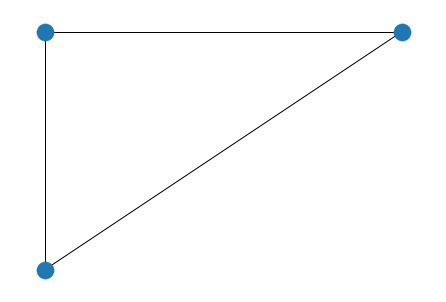

In [30]:
# ネットワークの可視化

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

# 辺の設定
G.add_edge("nodeA", "nodeB")
G.add_edge("nodeA", "nodeC")
G.add_edge("nodeB", "nodeC")

# 座標の設定
pos = {}
pos["nodeA"] = (0, 0)
pos["nodeB"] = (1, 1)
pos["nodeC"] = (0, 1)

# 描画
nx.draw(G, pos)

# 表示
plt.show()

### Knock54: ネットワークにノード（頂点）を追加する

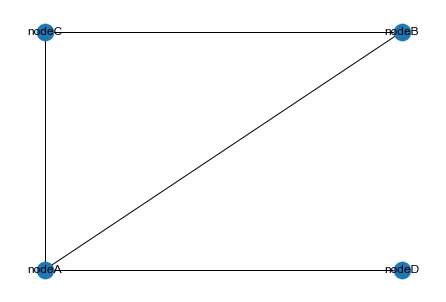

In [31]:
# 新たに頂点"nodeD"を追加する

G.add_node("nodeD")
G.add_edge("nodeA", "nodeD")
pos["nodeD"] = (1, 0)
nx.draw(G, pos, with_labels=True)

### Knock55: ルートの重み付けを実施する

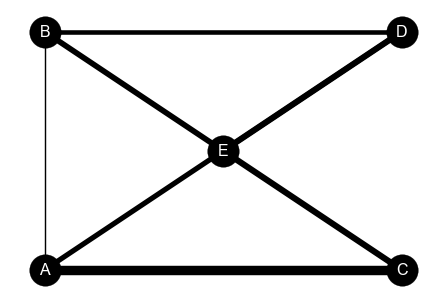

In [32]:
# ルートに重みをつける

# データの読み込み
# リンクごとの重み
df_w = pd.read_csv("../support/6章/network_weight.csv")
# 各リンクの位置
df_p = pd.read_csv("../support/6章/network_pos.csv")

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 辺の設定とエッジの重みのリスト化
size = 10
edge_weights = []
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        if not (i == j):
            # 変の追加
            G.add_edge(df_w.columns[i], df_w.columns[j])
            # エッジの重みの追加
            edge_weights.append(df_w.loc[i][j]*size)

# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0], df_p[node][1])

# 描画
nx.draw(
    G, pos, with_labels=True, 
    font_size=16, font_color="w", 
    node_size=1000, node_color="k",
    width=edge_weights
)

# 表示
plt.show()

### Knock56: 輸送ルート情報を読み込む

- trans.route.csv（輸送ルート）
- trans.route_pos.csv（倉庫・工場の位置情報）
- trans.cost.csv（倉庫と工場間の輸送コスト）
- demand.csv（工場の製品生産量に対する需要）
- supply.csv（倉庫が供給可能な部品数の上限）
- trans.route_new.csv（新しく設計し直した輸送ルート）

In [58]:
# ルート情報の読み込み

df_tr = pd.read_csv("../support/6章/trans_route.csv")
print(df_tr.shape)
display(df_tr)

(3, 5)


,工場,F1,F2,F3,F4
0,W1,15,15,0,5
1,W2,5,0,30,5
2,W3,10,15,2,15


### Knock57: 輸送ルート情報からネットワークを可視化する

In [70]:
# データの読み込み

# ルート情報
df_tr = pd.read_csv("../support/6章/trans_route.csv", index_col="工場")
# 位置情報
df_pos = pd.read_csv("../support/6章/trans_route_pos.csv")

display(df_tr)
display(df_pos)

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0000,4.0000,4.0000,4.0000
1,1,2,3,0.5000,1.5000,2.5000,3.5000


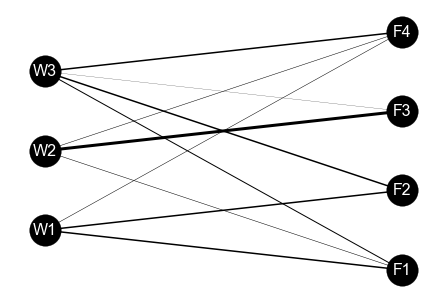

In [71]:
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    # ['W1', 'W2', 'W3', 'F1', 'F2', 'F3', 'F4']
    G.add_node(df_pos.columns[i])

# 辺の設定とエッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):

            # 辺の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # [('W1', 'W2'), ('W1', 'W3'), ('W1', 'F1'), ('W1', 'F2'), ('W1', 'F3'), ('W1', 'F4'), 
            # ('W2', 'W3'), ('W2', 'F1'), ('W2', 'F2'), ('W2', 'F3'), ('W2', 'F4'), 
            # ('W3', 'F1'), ('W3', 'F2'), ('W3', 'F3'), ('W3', 'F4'), 
            # ('F1', 'F2'), ('F1', 'F3'), ('F1', 'F4'), 
            # ('F2', 'F3'), ('F2', 'F4'), 
            # ('F3', 'F4')]
            
            # エッジの重みの追加
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                # df_tr.index = ['W1', 'W2', 'W3']
                # df_tr.columns = ['工場', 'F1', 'F2', 'F3', 'F4']
                # df_pos.columns = ['W1', 'W2', 'W3', 'F1', 'F2', 'F3', 'F4']
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
                edge_weights.append(weight)

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

# 描画
nx.draw(
    G, pos, with_labels=True,
    font_size=16, font_color="w",
    node_size=1000, node_color="k",
    width=edge_weights
)

# 表示
plt.show()

### Knock58: 輸送コスト関数を作成する

- 最適化問題
  - 目的関数
    - 最小化（最大化）したいものを関数として定義
  - 制約条件
    - 最小化（最大化）を行うにあたって、守るべき条件を定義
  - 制約条件を満たした上で、目的関数を最小化（最大化）する組み合わせを選択する

- 「輸送コスト下げられる効率的な輸送ルートがあるのではないか？」
  - 輸送コストを計算する関数の作成

In [74]:
# 輸送コストを計算する関数の作成

# ルート情報の読み込み
df_tr = pd.read_csv("../support/6章/trans_route.csv", index_col="工場")
# 位置情報の読み込み
df_tc = pd.read_csv("../support/6章/trans_cost.csv", index_col="工場")

display(df_tr)
display(df_tc)

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [76]:
# 輸送コスト関数

def trans_cost(df_tr: pd.DataFrame, df_tc: pd.DataFrame):
    """輸送コスト計算する"""
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
    
    return cost

In [78]:
# 輸送コストの計算

print(f"総輸送コスト: {trans_cost(df_tr, df_tc)} 万円")

総輸送コスト: 1493 万円


### Knock59: 制約条件を作る

In [79]:
# データの読み込み

# ルート情報
df_tr = pd.read_csv("../support/6章/trans_route.csv", index_col="工場")

# 各工場の満たすべき最低限の製品製造量
df_demand = pd.read_csv("../support/6章/demand.csv")

# 各倉庫の供給可能な部品数
df_supply = pd.read_csv("../support/6章/supply.csv")

display(df_tr)
display(df_demand)
display(df_supply)

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [80]:
# 制約条件の作成

# 需要側（工場）の制約条件
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(f"工場 {df_demand.columns[i]} への輸送量: {temp_sum} （需要量: {df_demand.iloc[0][i]}）")
    if temp_sum >= df_demand.iloc[0][i]:
        print("需要量を満たしています。\n")
    else:
        print("需要量を満たしていません。輸送ルートを再計算してください。\n")

# 供給側（倉庫）の制約条件
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(f"倉庫 {df_supply.columns[i]} からの輸送量: {temp_sum} （供給限界: {df_supply.iloc[0][i]}）")
    if temp_sum <= df_supply.iloc[0][i]:
        print("供給限界の範囲内です。\n")
    else:
        print("供給限界を超過しています。輸送ルートを再計算してください。\n")

工場 F1 への輸送量: 30 （需要量: 28）
需要量を満たしています。

工場 F2 への輸送量: 30 （需要量: 29）
需要量を満たしています。

工場 F3 への輸送量: 32 （需要量: 31）
需要量を満たしています。

工場 F4 への輸送量: 25 （需要量: 25）
需要量を満たしています。

倉庫 W1 からの輸送量: 35 （供給限界: 35）
供給限界の範囲内です。

倉庫 W2 からの輸送量: 40 （供給限界: 41）
供給限界の範囲内です。

倉庫 W3 からの輸送量: 42 （供給限界: 42）
供給限界の範囲内です。



### Knock60: 輸送ルートを変更して、輸送コスト関数の変化を確認する

In [82]:
# 変更した輸送ルートで、輸送コストを計算する

# データの読み込み
df_tr_new = pd.read_csv("../support/6章/trans_route_new.csv", index_col="工場")
display(df_tr_new)

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [83]:
# 総輸送コストの再計算

print(f"総輸送コスト（変更前）: {trans_cost(df_tr, df_tc)} 万円")
print(f"総輸送コスト（変更後）: {trans_cost(df_tr_new, df_tc)} 万円")

総輸送コスト（変更前）: 1493 万円
総輸送コスト（変更後）: 1428 万円


In [100]:
# 制約条件計算関数

# 需要側（工場）
def condition_demand(df_tr: pd.DataFrame, df_demand: pd.DataFrame):
    """要求されている需要量をみたしているかを確認する"""
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1

    return flag

# 供給側（倉庫）
def condition_supply(df_tr: pd.DataFrame, df_supply: pd.DataFrame):
    """供給限界量超えていないかを確認する"""
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if (temp_sum <= df_supply.iloc[0][i]):
            flag[i] = 1

    return flag

In [101]:
# 新しい輸送ルートが制約条件を満たしているかの確認

print(f"需要条件計算結果（変更前）: {condition_demand(df_tr, df_demand)}")
print(f"供給条件計算結果（変更前）: {condition_supply(df_tr, df_supply)}\n")
print(f"需要条件計算結果（変更後）: {condition_demand(df_tr_new, df_demand)}")
print(f"供給条件計算結果（変更後）: {condition_supply(df_tr_new, df_supply)}")

需要条件計算結果（変更前）: [1. 1. 1. 1.]
供給条件計算結果（変更前）: [1. 1. 1.]

需要条件計算結果（変更後）: [1. 1. 1. 1.]
供給条件計算結果（変更後）: [1. 0. 1.]
